<a href="https://colab.research.google.com/github/rkj26/deep-orderbook/blob/rakshit_jha/CoinBase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!wget -O dataset.7z https://www.dropbox.com/sh/w3qagq2ze9noxon/AACE6f4nkBAJaJEc7Nbf2nhla/coinbase_btc_usd.7z?dl=0

In [0]:
%%capture
!pip install pyunpack
!pip install patool

In [0]:
from pyunpack import Archive

In [0]:
Archive('/content/dataset.7z').extractall("/content")

In [0]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [0]:
path_ = '/content/coinbase_btc_usd/coinbase/btc_usd/l2_snapshots/100ms/'

In [0]:
l2_snapshot = pd.read_parquet('/content/coinbase_btc_usd/coinbase/btc_usd/l2_snapshots/100ms/coinbase_btc_usd_l2_book_snapshots_depth50_2019_11_12_0000_0100.parquet')

In [0]:
l2_snapshot.head()

,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19,b20,b21,b22,b23,b24,b25,b26,b27,b28,b29,b30,b31,b32,b33,b34,b35,b36,b37,b38,b39,b40,...,aq11,aq12,aq13,aq14,aq15,aq16,aq17,aq18,aq19,aq20,aq21,aq22,aq23,aq24,aq25,aq26,aq27,aq28,aq29,aq30,aq31,aq32,aq33,aq34,aq35,aq36,aq37,aq38,aq39,aq40,aq41,aq42,aq43,aq44,aq45,aq46,aq47,aq48,aq49,aq50
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-11-12 00:00:00.000,8721.53,8720.59,8719.55,8719.50,8719.0,8718.02,8717.87,8717.85,8717.56,8716.06,8716.00,8715.29,8715.00,8714.97,8714.61,8714.20,8713.93,8712.43,8712.41,8712.09,8710.56,8710.55,8710.00,8708.91,8708.69,8708.68,8708.19,8708.13,8707.99,8705.89,8705.21,8705.00,8704.09,8704.08,8703.0,8702.34,8701.50,8700.99,8700.60,8700.36,...,0.08,0.630734,5.999000,1.116316,0.00224,1.00000,0.04,0.005,0.001889,4.100000,1.0,1.060263,1.000000,0.4099,2.0000,1.5,0.01,0.68713,0.25000,1.141294,3.500000,0.092358,0.688130,0.67100,0.2335,0.689853,0.747313,1.640000,1.042177,0.009135,8.200000,2.203,2.600,0.005,2.500,0.896321,0.766000,0.001737,1.820000,0.933419
2019-11-12 00:00:00.100,8721.53,8720.59,8719.56,8719.55,8719.0,8718.02,8717.87,8717.85,8717.56,8716.06,8716.00,8715.29,8715.00,8714.97,8714.61,8714.20,8713.93,8712.43,8712.41,8712.09,8710.56,8710.55,8710.00,8708.91,8708.69,8708.68,8708.19,8708.13,8707.99,8705.89,8705.21,8705.00,8704.09,8704.08,8703.0,8702.34,8701.50,8700.99,8700.60,8700.36,...,0.08,0.630734,5.999000,1.116316,0.00224,1.00000,0.04,0.005,0.001889,4.100000,1.0,1.060263,1.000000,0.4099,2.0000,1.5,0.01,0.68713,0.25000,1.141294,3.500000,0.092358,0.688130,0.67100,0.2335,0.689853,0.747313,1.640000,1.042177,0.009135,8.200000,2.203,2.600,0.005,2.500,0.896321,0.766000,0.001737,1.820000,0.933419
2019-11-12 00:00:00.200,8721.53,8720.59,8719.61,8719.56,8719.0,8718.02,8717.87,8717.85,8716.06,8716.00,8715.29,8715.00,8714.61,8714.20,8713.93,8712.43,8712.41,8712.09,8710.56,8710.55,8710.00,8708.91,8708.69,8708.68,8708.19,8708.13,8707.99,8705.89,8705.21,8705.00,8704.09,8704.08,8703.00,8702.34,8701.5,8700.99,8700.60,8700.36,8700.02,8700.00,...,1.00,0.080000,0.630734,5.999000,0.03030,0.00224,1.00,0.040,0.005000,0.001889,4.1,1.000000,1.060263,1.0000,0.4099,2.0,1.50,0.01000,0.68713,0.250000,1.141294,3.500000,0.092358,0.68813,0.6710,0.233500,0.689853,0.747313,1.640000,1.042177,0.009135,8.200,2.203,2.600,0.005,2.500000,0.896321,0.766000,0.001737,1.820000
2019-11-12 00:00:00.300,8721.53,8720.59,8719.61,8719.56,8719.0,8718.02,8718.00,8717.87,8717.85,8716.60,8716.06,8716.00,8715.29,8715.00,8714.61,8714.20,8713.93,8713.10,8712.41,8712.09,8710.56,8710.55,8710.26,8710.00,8708.91,8708.69,8708.19,8708.13,8707.99,8705.89,8705.00,8704.09,8704.08,8703.00,8701.5,8700.99,8700.60,8700.36,8700.02,8700.00,...,1.00,0.080000,0.630734,5.999000,0.03030,0.00224,1.00,0.040,0.005000,0.001889,4.1,1.000000,1.060263,1.0000,0.4099,2.0,1.50,0.01000,0.68713,0.250000,1.141294,3.500000,0.092358,0.68813,0.6710,0.233500,0.689853,0.747313,1.640000,1.042177,0.009135,8.200,2.203,2.600,0.005,2.500000,0.896321,0.766000,0.001737,1.820000
2019-11-12 00:00:00.400,8721.53,8720.59,8719.61,8719.56,8719.0,8718.99,8718.02,8718.00,8717.87,8717.85,8716.60,8716.06,8716.00,8715.29,8715.00,8714.61,8714.20,8713.93,8713.10,8712.41,8712.09,8710.56,8710.55,8710.26,8710.00,8708.91,8708.69,8708.19,8708.13,8707.99,8705.89,8705.00,8704.09,8704.08,8703.0,8701.50,8700.99,8700.60,8700.36,8700.02,...,1.00,0.080000,0.630734,5.999000,0.03030,0.00224,1.00,0.040,0.005000,0.001889,4.1,1.000000,1.060263,1.0000,0.4099,2.0,1.50,0.01000,0.68713,0.250000,1.141294,3.500000,0.092358,0.68813,0.6710,0.233500,0.689853,0.747313,1.640000,1.042177,0.009135,8.200,2.203,2.600,0.005,2.500000,0.896321,0.766000,0.001737,1.820000


In [0]:
i = 0
for x in os.listdir(path_):
  #Remove the if part to load the full dataset
  if i > 10:
    break
  else:
    if i == 0:
      l2_snapshot = pd.read_parquet('/content/coinbase_btc_usd/coinbase/btc_usd/l2_snapshots/100ms/coinbase_btc_usd_l2_book_snapshots_depth50_2019_11_12_0000_0100.parquet')
    else:
      temp = pd.read_parquet(path_+x)
      l2_snapshot_ = l2_snapshot.copy()
      l2_snapshot = pd.concat([l2_snapshot_, temp])
      del temp
      del l2_snapshot_
      gc.collect()
    i = i+1
print('Memory Usage: {} MB'.format(l2_snapshot.memory_usage().sum()/(1024**2)))

True
True
True
True
True
True
True
True
True
True
True
Memory Usage: 607.2401504516602


In [0]:
print('Before dropping null values: {}'.format(l2_snapshot.shape))
l2_snapshot.dropna(inplace=True)
print('After dropping null values: {}'.format(l2_snapshot.shape))

(395981, 200)

In [0]:
# Function to generate the labels for learning
def generate_features_labels(df,ask, bid,k=20, alpha = 10e-6):
  df_ = df.copy()
  df_['mid_price'] = (df_[ask]+df_[bid])/2
  df_['target'] = 1
  index = df_.columns.get_loc('mid_price')
  target_index = df_.columns.get_loc('target')
  shape = df_.shape[0]
  for i in tqdm(range(k,shape-k)):
    m_b = np.mean(df_.iloc[(i-k):i, index].values)
    m_a = np.mean(df_.iloc[i+1:(i+k+1), index].values)

    if (m_b > m_a*(1+alpha)):
      df_.iloc[i,target_index] = 2
    if (m_b < m_a*(1-alpha)):
      df_.iloc[i,target_index] = 0

  y = df_.iloc[k:shape-k, target_index].values
  X = df.iloc[k:shape-k,:].values
  #Free up memory by deleting not required dataframes.
  del df_
  del df
  gc.collect()
  return X,y

In [0]:
X,y = generate_features_labels(l2_snapshot, ask='a1', bid = 'b1')

NameError: ignored

In [0]:
T = 100
D = 200
N = len(X) - T

In [0]:
trainPart = int(len(X)*0.7)  #(70% Data for training and 30% for testing)
scaler = StandardScaler()
scaler.fit(X[:trainPart + T - 1])
X = scaler.transform(X)

In [0]:
#Create the template structure of training set
X_train = np.zeros((trainPart, T, D))
Y_train = np.zeros(trainPart)

#Preparing the time series data using timestep of 100 and no of features = 200
for t in range(trainPart):
  X_train[t, :, :] = X[t:t+T]
  Y_train[t] = y[t+T] 

# Reducing X_train datasize memory usage
print('X_train - Before: {} GB'.format(X_train.nbytes/1024**3))
X_train = X_train.astype('float16')
print('X_train - After: {} GB'.format(X_train.nbytes/1024**3))

# Reducing Y_train datasize memory usage
print('Y_train - before: {} GB'.format(Y_train.nbytes/1024**3))
Y_train = Y_train.astype('int16')
print('Y_train - After: {} GB'.format(Y_train.nbytes/1024**3))

26452.94189453125 1.3226470947265625


In [0]:
#Create the template structure of test set
X_test = np.zeros((N - trainPart, T, D))
Y_test = np.zeros(N - trainPart)

#Preparing the time series data using timestep of 100 and no of features = 200
for k in range(N - trainPart):
  t = k + trainPart
  X_test[k, :, :] = X[t:t+T]
  Y_test[k] = y[t+T]

# Reducing X_test datasize memory usage
print('X_test - Before {} GB'.format(X_test.nbytes/1024**3))
X_test = X_test.astype('float16')
print('X_test - After {} GB'.format(X_test.nbytes/1024**3))

# Reducing Y_test datasize memory usage
print('Y_test - Before: {} GB'.format(Y_test.nbytes/1024**3))
Y_test = Y_test.astype('int16')
print('Y_test - After: {} GB'.format(Y_test.nbytes/1024**3))

Before 11321.71630859375 MB
After 2830.4290771484375 MB


In [0]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-beta1

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.0.0


In [0]:
from tensorflow.keras.layers import Input, Conv1D, Conv2D, Flatten, MaxPooling1D, MaxPooling2D, Dense, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

In [0]:
#Converting X_train and X_test for 2D Convolution
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

In [0]:
#Model architecture is as from the report
#T = 100 from the above step for timesteps and D = 200 (no. of features) 
i = Input(shape=X_train[0].shape)
print(i)
x = Conv2D(16, (4,D), activation=LeakyReLU(alpha=0.01))(i)
print(x.shape)
x = tf.keras.layers.Reshape(target_shape=(T-3,16))(x)
print(x.shape)
x = Conv1D(16, 4, activation=LeakyReLU(alpha=0.01))(x)
x = MaxPooling1D(2)(x)
x = Conv1D(32, 3, activation=LeakyReLU(alpha=0.01))(x)
x = Conv1D(32, 3, activation=LeakyReLU(alpha=0.01))(x)
x = MaxPooling1D(2)(x)
x = Flatten()(x)
x = Dense(32, activation=LeakyReLU(alpha=0.01))(x)
x = Dense(3, activation='softmax')(x)

model = Model(i,x)

Tensor("input_1:0", shape=(None, 100, 200, 1), dtype=float32)
(None, 97, 1, 16)
(None, 97, 16)


In [0]:
#Printing Model Summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 200, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 97, 1, 16)         12816     
_________________________________________________________________
reshape (Reshape)            (None, 97, 16)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 94, 16)            1040      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 47, 16)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 45, 32)            1568      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 43, 32)            3104  

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#Accuracy is not a great metrics

In [0]:
from sklearn.utils.class_weight import compute_class_weight
def compute_class_weight(y):
    classes = np.unique(y)
    class_weight = compute_class_weight("balanced", classes, y)
    class_weights = dict(zip(classes, class_weight))
    return class_weights

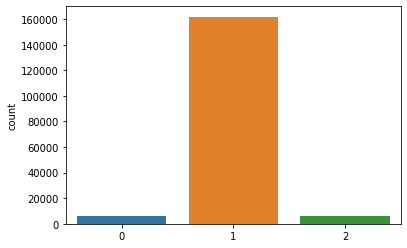

In [0]:
#computing class weights according to the percentage in training dataset
class_weights = compute_class_weight(Y_train)

In [0]:
EPOCHS = 50
BATCH_SIZE = 16
r = model.fit(
  X_train, Y_train,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_data=(X_test, Y_test),
  class_weight = class_weights
)

Train on 173362 samples, validate on 74198 samples
Epoch 1/50
173362/173362 [==============================] - 168s 967us/sample - loss: 0.1457 - accuracy: 0.9306 - val_loss: 3.9394 - val_accuracy: 0.8041
Epoch 2/50
173362/173362 [==============================] - 164s 945us/sample - loss: 0.1443 - accuracy: 0.9284 - val_loss: 6.0285 - val_accuracy: 0.8263
Epoch 3/50
173362/173362 [==============================] - 163s 941us/sample - loss: 0.1321 - accuracy: 0.9351 - val_loss: 6.7715 - val_accuracy: 0.8327
Epoch 4/50
173362/173362 [==============================] - 166s 955us/sample - loss: 0.1318 - accuracy: 0.9359 - val_loss: 4.1682 - val_accuracy: 0.7835
Epoch 5/50
173362/173362 [==============================] - 165s 954us/sample - loss: 0.1280 - accuracy: 0.9386 - val_loss: 3.7676 - val_accuracy: 0.7809
Epoch 6/50
173362/173362 [==============================] - 165s 952us/sample - loss: 0.1151 - accuracy: 0.9453 - val_loss: 6.1028 - val_accuracy: 0.8367
Epoch 7/50
173362/173362 

In [0]:
sns.lineplot(x=range(1,EPOCHS+1),y=r.history['loss'])
sns.lineplot(x=range(1,EPOCHS+1),y=r.history['val_loss'])
plt.title('Model Cross Entropy Loss')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Testing'], loc='upper left')

In [0]:
p_test = model.predict(X_test).argmax(axis=1)

In [0]:
 model.predict(X_test)

array([[9.9935645e-01, 6.4353470e-04, 5.4635085e-10],
       [9.9902296e-01, 9.7708602e-04, 8.1950363e-10],
       [9.9846858e-01, 1.5314259e-03, 1.1067330e-08],
       ...,
       [2.0005477e-03, 9.9799949e-01, 4.9733966e-08],
       [9.9095714e-04, 9.9900901e-01, 5.0577714e-08],
       [9.2293173e-03, 9.9077058e-01, 1.0115249e-07]], dtype=float32)

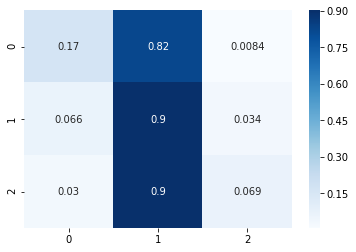

In [0]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_pred=p_test, y_true=Y_test)
    
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
ax=sns.heatmap(cm, annot=True, xticklabels=[0,1,2], yticklabels=[0,1,2], cmap='Blues')
ax.set_ylim(3.0, 0)
plt.show()

In [0]:
#Print the classification report
print(classification_report(y_true= Y_test, y_pred = p_test))

              precision    recall  f1-score   support

           0       0.10      0.17      0.13      3099
           1       0.91      0.90      0.90     67169
           2       0.10      0.07      0.08      3930

    accuracy                           0.83     74198
   macro avg       0.37      0.38      0.37     74198
weighted avg       0.83      0.83      0.83     74198

